# Two-Tier Urban Deliveries with Robots with no time windows

## MIP model
##### Decision variables:

| Variable |    |
|------|------|
|   $x_{c}^{wrd} = 1$| if robot $r=1, ..., r_{max}$ from hub $d$ serves customer $c$, where $d=1, ..., n; c\in C_{d}^{\omega}; \omega \in \Omega$|
|$x_{c}^{wrd} = 0$|otherwise|
|$o^{d}=1$|if hub $d$ is opened where $d=1,...,n$|
|$o^{d}=0$:|otherwise|

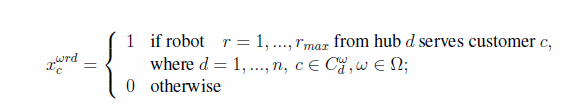

##### Objective Function
$$ min \sum_{d=1}^n o^{d}
$$


##### Constraints:
1.

| No. | Constraint   |
|------|------|
|   1  | table|

## Gurobi Model: First Attempt

In [46]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import numpy as np

In [47]:
def grid (a, n=None, spacing=None):
    """
    distribute n points evenly in a 2-dimensional square of side length a
    or create a square grid with suqare cells of length c
    """
    if spacing is None:
        assert n
        spacing = a // int(np.sqrt(n))
        base = range(spacing//2, a, spacing)
    if n is None:
        assert spacing
        base = range(0, a+1, spacing)
    return[(x,y) for x in base for y in base]

def travel_time(first, second, speed):  # speed in km/h
    dist = abs(first[0] - second[0]) + abs(first[1] - second[1])  # distance in km
    print(dist)
    return dist/speed  # travel time in hours

In [48]:
n = 100  # number of clients
h = 16  # number of potential hubs
r_max = 30  # number of robots per hub

area= 2  # 2km*2km square
block = 0.1  # 100m * 100m blocks
hub_cell = area/np.sqrt(h)

M = 50  # maximum allowed driving time per robot (hrs)
tf = 45/60  # robots' full recharge time (hrs)
b = 2  # robots' battery range (hrs)
ts = 4/60  # customer service time (hrs)
v = 3  # robot speed (km/h)

hubs_x , hubs_y = zip(*grid(a=area, n=h))

x, y = zip(*grid(a=area, spacing=block))

customers_x = np.random.choice(x, size=n)
customers_y = np.random.choice(y, size=n)

H = [i for i in range(h)]  # hubs
N = [i for i in range(n)]  # customers
R = [(i, j) for i in H for j in range(r_max)]  # (hubs, robots) tuples

V = H + N  # all locations
A = gp.tuplelist([(i, j) for i in V for j in V if i != j])  # all arcs
t = {(hub, customer): travel_time(first=(hubs_x[hub], hubs_y[hub]),
                                  second=(customers_x[customer], customers_y[customer]),
                                  speed=v)
     for hub in H for customer in N}  # Manhattan dist



ValueError: range() arg 3 must not be zero

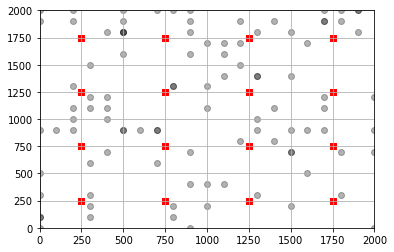

In [35]:
plt.scatter(hubs_x, hubs_y, c='r', marker='s')
plt.scatter(customers_x, customers_y, c='black', alpha=0.3)
plt.xlim(0, area)
plt.ylim(0, area)
plt.grid()

In [43]:
travel_time((0, 0), (0, 100), 10)

TypeError: travel_time() missing 1 required positional argument: 'speed'

### Minimize the number of hubs

In [ ]:
model = gp.Model('min_hubs')

In [ ]:
# add robot-hub-customer binary decision variables
x = model.addVars(R, N, vtype=GRB.BINARY)
# costs are not yet included
# these are too many variables, thus the paper uses only "reachable" customer-depot combinations

# add is-hub-open binary decision variables
o = model.addVars(H, vtype=GRB.BINARY)

model.setObjective(gp.quicksum(o), sense=GRB.MINIMIZE)

model.update()

In [ ]:
# All customer locations must be assigned to exactly one hub-robot combination
for customer in N:
    model.addConstr(x.sum('*', '*', customer) == 1)

In [ ]:
# limit on the maximum robot working time, which is based on the time required for the round 
# trip to customer locations, recharging time, and service time.
coeff = gp.tupledict({(hub, robot, customer): 2*t[hub, customer]*(1+(tf/b))+ts for hub, robot in R for customer in N})
for hub, robot in R:
    model.addConstr(x.prod(coeff, hub, robot, '*') <= M)

In [ ]:
# if a robot serves a customer location (in some instance omega), the corresponding robot hub is open
for hub in H:  # eventually this must iterate over all customers assigned to one hub ('reachable')
    for customer in N:
        model.addConstr(x.sum(hub, '*', customer) <= o.select(hub)[0])

In [ ]:
model.optimize()

In [ ]:
x_solution = model.getAttr('x', x)
{key[2]:key[0] for key, value in x_solution.items() if value > 0.5}  # customer: hub

In [ ]:
o_solution = model.getAttr('x', o)
o_solution

In [ ]:
for hub in H:
    if o_solution[hub] > 0.5:
        color = 'r'
    else:
        color='0.75'
    plt.scatter(xc[hub], yc[hub], c=color, marker='s')
for customer in N:
    plt.scatter(xc[customer], yc[customer], c='b')

In [ ]:
#for i, j in active:
#    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='c', zorder=0, alpha=0.2)
#for i in range(h):
#    plt.scatter(xc[i], yc[i], c='r', marker='s')
#for i in range(h, n+h):
#    plt.scatter(xc[i], yc[i], c='b')